In [1]:
from torchvision import datasets, transforms

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
conv = nn.Conv2d(3, 16, kernel_size = 3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
data_path = ".\\CIFAR10\\"

cifar10 = datasets.CIFAR10(
    data_path, train = True, download = False, 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [6]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

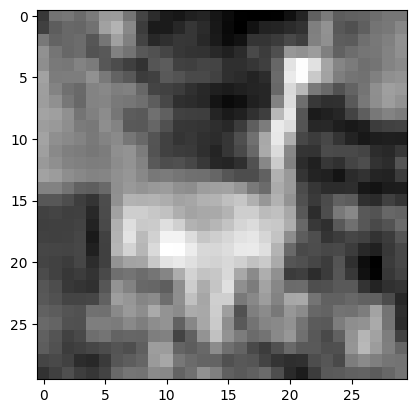

(None, torch.Size([1, 16, 30, 30]))

In [7]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show(), output.shape

In [8]:
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [9]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [10]:
conv.bias.shape, conv.weight.shape

(torch.Size([1]), torch.Size([1, 3, 3, 3]))

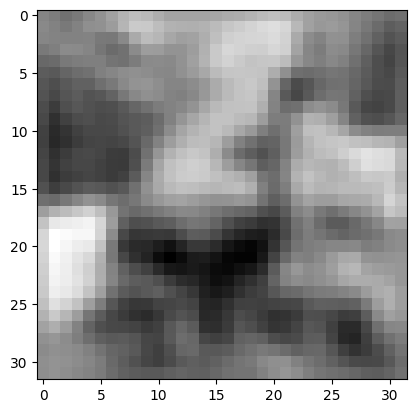

In [11]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap = 'gray')

In [12]:
conv = nn.Conv2d(3, 1, kernel_size = 3, padding = 1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    
    conv.bias.zero_()

## Pooling Layer

In [13]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

pool, img.unsqueeze(0).shape, output.shape

(MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 3, 16, 16]))

In [14]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [15]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [16]:
model(img.unsqueeze(0))    # Error

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

## Error Solution : nn.Sequential -> nn.Module

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [18]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]

sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [19]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [20]:
model = Net()
print(img.unsqueeze(0).shape)
model(img.unsqueeze(0))

torch.Size([1, 3, 32, 32])


tensor([[ 0.0296, -0.2178]], grad_fn=<AddmmBackward0>)

# Convolutional Neural Network - CPU

In [21]:
import datetime
import torch.optim as optim

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
        
            print(f"{datetime.datetime.now()} Epoch {epoch} Training loss {loss_train / len(train_loader)}")

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-01-13 23:48:39.171066 Epoch 1 Training loss 0.574258434544703
2023-01-13 23:48:55.723205 Epoch 10 Training loss 0.3236909317932311
2023-01-13 23:49:14.081250 Epoch 20 Training loss 0.2943898440356467
2023-01-13 23:49:32.366569 Epoch 30 Training loss 0.27259867557674455
2023-01-13 23:49:50.726918 Epoch 40 Training loss 0.2541073456786241
2023-01-13 23:50:09.165915 Epoch 50 Training loss 0.235073016659849
2023-01-13 23:50:27.723182 Epoch 60 Training loss 0.2168441867562616
2023-01-13 23:50:46.455599 Epoch 70 Training loss 0.20125140211764414
2023-01-13 23:51:05.111678 Epoch 80 Training loss 0.1864993579828056
2023-01-13 23:51:23.826064 Epoch 90 Training loss 0.17209468198240183
2023-01-13 23:51:42.316071 Epoch 100 Training loss 0.15738505457237267


In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim = 1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.89


In [24]:
torch.save(model.state_dict(), data_path + "birds_and_airplanes.pt")

## Save Model Load

In [25]:
load_model = Net()
load_model.load_state_dict(torch.load(data_path + "birds_and_airplanes.pt"))

<All keys matched successfully>

# Convolutional Neural Network - GPU

In [26]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

print(f"Traning on device {device}")

Traning on device cuda


In [27]:
import datetime
import torch.optim as optim

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            
            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f"{datetime.datetime.now()} Epoch {epoch} Training loss {loss_train / len(train_loader)}")

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model = Net().to(device = device)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-01-13 23:51:46.856511 Epoch 1 Training loss 0.5668012928810848
2023-01-13 23:51:50.471705 Epoch 10 Training loss 0.3315366112692341
2023-01-13 23:51:54.469616 Epoch 20 Training loss 0.29252463541213114
2023-01-13 23:51:58.475644 Epoch 30 Training loss 0.2664045634543061
2023-01-13 23:52:02.484415 Epoch 40 Training loss 0.24207403714869433
2023-01-13 23:52:06.476806 Epoch 50 Training loss 0.22666812901663932
2023-01-13 23:52:10.474050 Epoch 60 Training loss 0.21013992206211302
2023-01-13 23:52:14.466811 Epoch 70 Training loss 0.1957400370460407
2023-01-13 23:52:18.489482 Epoch 80 Training loss 0.18110271799526398
2023-01-13 23:52:22.486226 Epoch 90 Training loss 0.16862837035375036
2023-01-13 23:52:26.478781 Epoch 100 Training loss 0.15565049406259682
